## Mini-Project 3:  Computer Vision using GPU and Transfer Learning


#### CSC 180 Intelligent Systems

#### Dr. Haiquan Chen, California State University, Sacramento

In [1]:
# Insert your name, your id, course title, assignment id, and due date here as comment 

# Jonathan Jakab : 301917863 
# Jacob Hallum : 302382301 
# Mahdi Noureddine : 219660208 

# Professor Chen
# CSC 180-1 - Intelligent Systems
# Project 3: Computer Vision using GPU and Transfer Learning
# 10/28/2022 10:00AM


## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [2]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [3]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
#  Load cifar-10 data and split it to training and test
from tensorflow.keras.datasets import cifar10

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [5]:
# print out data shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [6]:
#  print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

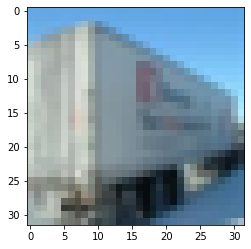

In [7]:
# print it out as image
import matplotlib.pyplot as plt

plt.imshow(x_train[15])

In [8]:
# Convert y_train from 2D to 1D 
y_train = y_train.reshape(50000)

In [9]:
y_train.shape
# expected output: (50000,)

(50000,)

In [10]:
# Convert y_test from 2D to 1D 
y_test = y_test.reshape(10000)

In [11]:
y_test.shape
# expected output: (10000,)

(10000,)

In [12]:
# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
# Convert data from int to float and normalize it
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

###  Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

### (optional) You are also encouraged to create multiple models with different activiation functions, different numbers of neurons and layers for performance comparison.

In [14]:
print(x_train.shape);

(50000, 32, 32, 3)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]);

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="relu_adam_CNN_noTL.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
  print('\nRun: ', i + 1)

  relu_adam_CNN_noTL = Sequential()
    
  relu_adam_CNN_noTL.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
  relu_adam_CNN_noTL.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  relu_adam_CNN_noTL.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
  relu_adam_CNN_noTL.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  relu_adam_CNN_noTL.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
  relu_adam_CNN_noTL.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  relu_adam_CNN_noTL.add(Flatten())
  relu_adam_CNN_noTL.add(Dense(1024, activation='relu'))
  relu_adam_CNN_noTL.add(Dropout(0.5))
  relu_adam_CNN_noTL.add(Dense(y_train.shape[1], activation='softmax'))


Run:  1

Run:  2

Run:  3


### Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

relu_adam_CNN_noTL.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

relu_adam_CNN_noTL.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

Epoch 1/600
1563/1563 - 15s - loss: 1.5208 - val_loss: 1.2542 - 15s/epoch - 9ms/step
Epoch 2/600
1563/1563 - 6s - loss: 1.1560 - val_loss: 1.1882 - 6s/epoch - 4ms/step
Epoch 3/600
1563/1563 - 8s - loss: 1.0043 - val_loss: 0.9944 - 8s/epoch - 5ms/step
Epoch 4/600
1563/1563 - 6s - loss: 0.9110 - val_loss: 0.9017 - 6s/epoch - 4ms/step
Epoch 5/600
1563/1563 - 6s - loss: 0.8379 - val_loss: 0.9101 - 6s/epoch - 4ms/step
Epoch 6/600
1563/1563 - 6s - loss: 0.7786 - val_loss: 0.8613 - 6s/epoch - 4ms/step
Epoch 7/600
1563/1563 - 6s - loss: 0.7297 - val_loss: 0.8456 - 6s/epoch - 4ms/step
Epoch 8/600
1563/1563 - 6s - loss: 0.6871 - val_loss: 0.8405 - 6s/epoch - 4ms/step
Epoch 9/600
1563/1563 - 6s - loss: 0.6505 - val_loss: 0.8570 - 6s/epoch - 4ms/step
Epoch 10/600
1563/1563 - 6s - loss: 0.6118 - val_loss: 0.8336 - 6s/epoch - 4ms/step
Epoch 11/600
1563/1563 - 6s - loss: 0.5859 - val_loss: 0.8584 - 6s/epoch - 4ms/step
Epoch 12/600
1563/1563 - 6s - loss: 0.5536 - val_loss: 0.8568 - 6s/epoch - 4ms/step

### **Note: This was added purely for running the code. Whenever the cells ran seperatly, only one run would be executed. Not the 3 that are set up.**

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]);

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="relu_adam_CNN_noTL.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
  print('\nRun: ', i + 1)

  relu_adam_CNN_noTL = Sequential()
    
  relu_adam_CNN_noTL.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
  relu_adam_CNN_noTL.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  relu_adam_CNN_noTL.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
  relu_adam_CNN_noTL.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  relu_adam_CNN_noTL.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
  relu_adam_CNN_noTL.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  relu_adam_CNN_noTL.add(Flatten())
  relu_adam_CNN_noTL.add(Dense(1024, activation='relu'))
  relu_adam_CNN_noTL.add(Dropout(0.5))
  relu_adam_CNN_noTL.add(Dense(y_train.shape[1], activation='softmax'))

  relu_adam_CNN_noTL.compile(loss='categorical_crossentropy', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  relu_adam_CNN_noTL.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
1563/1563 - 16s - loss: 1.5351 - val_loss: 1.2473 - 16s/epoch - 10ms/step
Epoch 2/600
1563/1563 - 6s - loss: 1.1670 - val_loss: 1.0633 - 6s/epoch - 4ms/step
Epoch 3/600
1563/1563 - 6s - loss: 1.0262 - val_loss: 0.9886 - 6s/epoch - 4ms/step
Epoch 4/600
1563/1563 - 6s - loss: 0.9338 - val_loss: 0.9434 - 6s/epoch - 4ms/step
Epoch 5/600
1563/1563 - 6s - loss: 0.8655 - val_loss: 0.9029 - 6s/epoch - 4ms/step
Epoch 6/600
1563/1563 - 6s - loss: 0.8119 - val_loss: 0.8752 - 6s/epoch - 4ms/step
Epoch 7/600
1563/1563 - 6s - loss: 0.7652 - val_loss: 0.9172 - 6s/epoch - 4ms/step
Epoch 8/600
1563/1563 - 8s - loss: 0.7215 - val_loss: 0.8684 - 8s/epoch - 5ms/step
Epoch 9/600
1563/1563 - 7s - loss: 0.6873 - val_loss: 0.9156 - 7s/epoch - 4ms/step
Epoch 10/600
1563/1563 - 6s - loss: 0.6579 - val_loss: 0.8927 - 6s/epoch - 4ms/step
Epoch 11/600
1563/1563 - 6s - loss: 0.6296 - val_loss: 0.8713 - 6s/epoch - 4ms/step
Epoch 12/600
1563/1563 - 6s - loss: 0.6029 - val_loss: 0.9131 - 6s/epoch 

In [16]:
# Print model summary
relu_adam_CNN_noTL.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 64)        

### Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

In [17]:
from sklearn import metrics
from tensorflow.keras.models import load_model

relu_adam_CNN_noTL = load_model('relu_adam_CNN_noTL.hdf5')

y_true = np.argmax(y_test, axis=1)

relu_adam_CNN_noTL_pred = relu_adam_CNN_noTL.predict(x_test)
relu_adam_CNN_noTL_pred = np.argmax(relu_adam_CNN_noTL_pred, axis=1)

relu_adam_CNN_noTL_acc = metrics.accuracy_score(y_true, relu_adam_CNN_noTL_pred)
relu_adam_CNN_noTL_prec = metrics.precision_score(y_true, relu_adam_CNN_noTL_pred, average= "weighted")
relu_adam_CNN_noTL_recall = metrics.recall_score(y_true, relu_adam_CNN_noTL_pred, average= "weighted")
relu_adam_CNN_noTL_f1 = metrics.f1_score(y_true, relu_adam_CNN_noTL_pred, average= "weighted")

print('Accuracy of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_noTL_acc))
print('Precision of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_noTL_prec))
print('Recall of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_noTL_recall))
print('F1 Score of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_noTL_f1))
print("\n");
print(metrics.classification_report(y_true, relu_adam_CNN_noTL_pred))

313/313 [==============================] - 1s 2ms/step
Accuracy of CNN with No Transfer Learning: 0.7102
Precision of CNN with No Transfer Learning: 0.7126109776929308
Recall of CNN with No Transfer Learning: 0.7102
F1 Score of CNN with No Transfer Learning: 0.7083093576610396


              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1000
           1       0.86      0.81      0.83      1000
           2       0.61      0.62      0.62      1000
           3       0.52      0.54      0.53      1000
           4       0.75      0.56      0.64      1000
           5       0.63      0.60      0.61      1000
           6       0.75      0.82      0.78      1000
           7       0.74      0.77      0.75      1000
           8       0.76      0.84      0.80      1000
           9       0.71      0.87      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg    

### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model.

### Include your findings in the project report.

In [18]:
x_test.shape

(10000, 32, 32, 3)


Image: #5926

True Label: 4

True Category: deer


Predicted Label using No Transfer Learning Model: 0

Predicted Category using No Transfer Learning Model: airplane



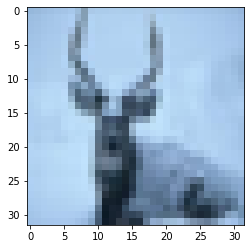


Image: #5062

True Label: 5

True Category: dog


Predicted Label using No Transfer Learning Model: 6

Predicted Category using No Transfer Learning Model: frog



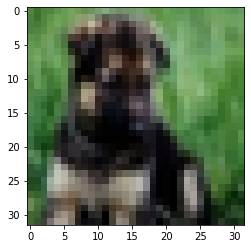


Image: #6380

True Label: 3

True Category: cat


Predicted Label using No Transfer Learning Model: 5

Predicted Category using No Transfer Learning Model: dog



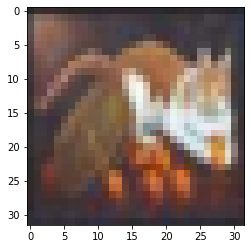


Image: #6139

True Label: 9

True Category: truck


Predicted Label using No Transfer Learning Model: 9

Predicted Category using No Transfer Learning Model: truck



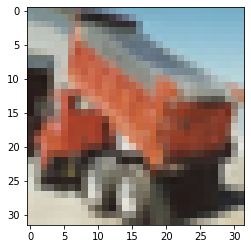


Image: #492

True Label: 8

True Category: ship


Predicted Label using No Transfer Learning Model: 8

Predicted Category using No Transfer Learning Model: ship



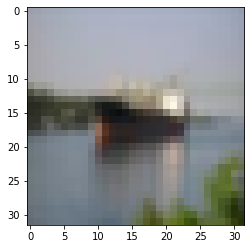

In [18]:
import random

# Category Type Was Obtained From Documentation Found At: https://www.cs.toronto.edu/~kriz/cifar.html
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(5):
  randNum = random.randint(0, 9999)
  randImage = x_test[randNum];

  print("=========================================");
  plt.imshow(randImage)

  print(f"\nImage: #{randNum}\n");
  print(f"True Label: {y_true[randNum]}\n");
  print(f"True Category: {categories[y_true[randNum]]}\n\n");
  print(f"Predicted Label using No Transfer Learning Model: {relu_adam_CNN_noTL_pred[randNum]}\n");
  print(f"Predicted Category using No Transfer Learning Model: {categories[relu_adam_CNN_noTL_pred[randNum]]}\n");

  plt.show();




## Part II:   CNN model with Transfer Learning

In [19]:
# We load data again. The data split between train and test sets:
from tensorflow.keras.datasets import cifar10

num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Hints: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### Learn from the examples here:  https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html

#### (2) Apply upsampling to x_train and x_test seperately. 

In [21]:
x_test.shape

(10000, 32, 32, 3)

In [20]:
from skimage.transform import resize

#hint: use np.zeros() to initialize an all-zero numpy array with desirable size and then assign each resized image into it
x_train = tf.image.resize(x_train, (64, 64))
x_test = tf.image.resize(x_test, (64, 64))
print(x_train.shape)
print(x_test.shape)
# this process may take about a few minutes ....

(50000, 64, 64, 3)
(10000, 64, 64, 3)


In [21]:
#hint: use np.zeros() to initialize an all-zero numpy array with desirable size and then assign each resized image into it
x_train = x_train.numpy()
x_test = x_test.numpy()
print(type(x_train))
print(type(x_test))
# this process may take about a few minutes ....

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [22]:
# Convert y_train from 2D to 1D 
y_train = y_train.reshape(50000)

# Convert y_test from 2D to 1D 
y_test = y_test.reshape(10000)

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train /= 255
x_test /= 255

In [23]:
# double check shape
print(y_train.shape)
print(y_test.shape)
# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000, 10)
(10000, 10)


###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="relu_adam_CNN_TL.hdf5", verbose=0, save_best_only=True)

# write your code here

# Run model training multiple times to jump out of local optimum 
for i in range(1):
  print('\nRun: ', i + 1)

  relu_adam_CNN_TL = Sequential()
    
  #Adding VGG16 Layer 
  for layer in vgg_model.layers:
    relu_adam_CNN_TL.add(layer)


Run:  1


### Write your code in the cell below to freeze the weights in each layer in the new model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Freezing the layers
for layer in relu_adam_CNN_TL.layers:
  layer.trainable = False

###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten

# Add some "Dense" layers here, including output layer
relu_adam_CNN_TL.add(Flatten())
relu_adam_CNN_TL.add(Dense(1024, activation='relu'))
relu_adam_CNN_TL.add(Dropout(0.5))
relu_adam_CNN_TL.add(Dense(y_train.shape[1], activation='softmax'))

###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

relu_adam_CNN_TL.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
relu_adam_CNN_TL.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Epoch 1/600


### **Note: This was added purely for running the code. Whenever the cells ran seperatly, only one run would be executed. Not the 3 that are set up.**


In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]);
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

# write your code here
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="relu_adam_CNN_TL.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(1):
  print('\nRun: ', i + 1)

  relu_adam_CNN_TL = Sequential()
    
  #Adding VGG16 Layer 
  for layer in vgg_model.layers:
    relu_adam_CNN_TL.add(layer)

  # Freezing the layers
  for layer in relu_adam_CNN_TL.layers:
    layer.trainable = False

  relu_adam_CNN_TL.add(Flatten())
  relu_adam_CNN_TL.add(Dense(1024, activation='relu'))
  relu_adam_CNN_TL.add(Dropout(0.5))
  relu_adam_CNN_TL.add(Dense(y_train.shape[1], activation='softmax'))

  relu_adam_CNN_TL.compile(loss='categorical_crossentropy', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  relu_adam_CNN_TL.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

58889256/58889256 [==============================] - 3s 0us/step

Run:  1
Epoch 1/600
1563/1563 - 34s - loss: 1.2388 - val_loss: 1.0007 - 34s/epoch - 22ms/step
Epoch 2/600
1563/1563 - 37s - loss: 1.0471 - val_loss: 0.9408 - 37s/epoch - 24ms/step
Epoch 3/600
1563/1563 - 32s - loss: 0.9835 - val_loss: 0.9268 - 32s/epoch - 20ms/step
Epoch 4/600
1563/1563 - 32s - loss: 0.9359 - val_loss: 0.9374 - 32s/epoch - 20ms/step
Epoch 5/600
1563/1563 - 32s - loss: 0.8968 - val_loss: 0.9031 - 32s/epoch - 20ms/step
Epoch 6/600
1563/1563 - 32s - loss: 0.8712 - val_loss: 0.8851 - 32s/epoch - 20ms/step
Epoch 7/600
1563/1563 - 32s - loss: 0.8428 - val_loss: 0.8732 - 32s/epoch - 20ms/step
Epoch 8/600
1563/1563 - 32s - loss: 0.8141 - val_loss: 0.8868 - 32s/epoch - 20ms/step
Epoch 9/600
1563/1563 - 32s - loss: 0.7880 - val_loss: 0.8699 - 32s/epoch - 20ms/step
Epoch 10/600
1563/1563 - 32s - loss: 0.7641 - val_loss: 0.8655 - 32s/epoch - 20ms/step
Epoch 11/600
1563/1563 - 32s - loss: 0.7456 - val_loss: 0.8690 - 

In [ ]:
# print out the model summary
relu_adam_CNN_TL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [ ]:
from sklearn import metrics
from tensorflow.keras.models import load_model

relu_adam_CNN_TL = load_model('relu_adam_CNN_TL.hdf5')

y_true = np.argmax(y_test, axis=1)

relu_adam_CNN_TL_pred = relu_adam_CNN_TL.predict(x_test)
relu_adam_CNN_TL_pred = np.argmax(relu_adam_CNN_TL_pred, axis=1)

relu_adam_CNN_TL_acc = metrics.accuracy_score(y_true, relu_adam_CNN_TL_pred)
relu_adam_CNN_TL_prec = metrics.precision_score(y_true, relu_adam_CNN_TL_pred, average= "weighted")
relu_adam_CNN_TL_recall = metrics.recall_score(y_true, relu_adam_CNN_TL_pred, average= "weighted")
relu_adam_CNN_TL_f1 = metrics.f1_score(y_true, relu_adam_CNN_TL_pred, average= "weighted")

print('Accuracy of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_TL_acc))
print('Precision of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_TL_prec))
print('Recall of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_TL_recall))
print('F1 Score of CNN with No Transfer Learning: {}'.format(relu_adam_CNN_TL_f1))
print("\n");
print(metrics.classification_report(y_true, relu_adam_CNN_TL_pred))

313/313 [==============================] - 5s 16ms/step
Accuracy of CNN with No Transfer Learning: 0.7066
Precision of CNN with No Transfer Learning: 0.7102843075150282
Recall of CNN with No Transfer Learning: 0.7066
F1 Score of CNN with No Transfer Learning: 0.7067330393213891


              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1000
           1       0.81      0.79      0.80      1000
           2       0.60      0.69      0.64      1000
           3       0.50      0.57      0.53      1000
           4       0.68      0.63      0.65      1000
           5       0.69      0.53      0.60      1000
           6       0.71      0.74      0.72      1000
           7       0.76      0.75      0.76      1000
           8       0.79      0.84      0.82      1000
           9       0.79      0.79      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg   

### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.


Image: #1439

True Label: 9

True Category: truck


Predicted Label using No Transfer Learning Model: 1

Predicted Category using No Transfer Learning Model: automobile



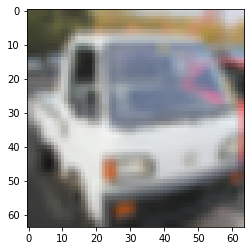


Image: #2915

True Label: 5

True Category: dog


Predicted Label using No Transfer Learning Model: 5

Predicted Category using No Transfer Learning Model: dog



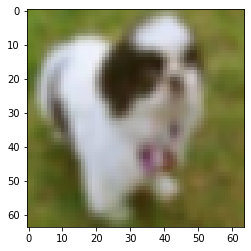


Image: #1397

True Label: 0

True Category: airplane


Predicted Label using No Transfer Learning Model: 0

Predicted Category using No Transfer Learning Model: airplane



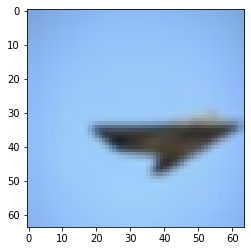


Image: #1299

True Label: 7

True Category: horse


Predicted Label using No Transfer Learning Model: 2

Predicted Category using No Transfer Learning Model: bird



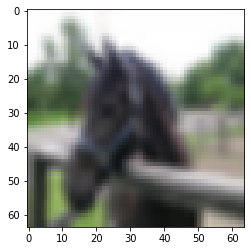


Image: #2823

True Label: 3

True Category: cat


Predicted Label using No Transfer Learning Model: 3

Predicted Category using No Transfer Learning Model: cat



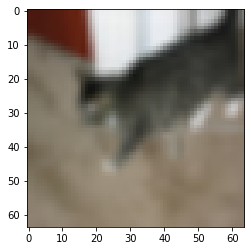

In [ ]:
import random

# Category Type Was Obtained From Documentation Found At: https://www.cs.toronto.edu/~kriz/cifar.html
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(5):
  randNum = random.randint(0, 5000)
  randImage = x_test[randNum];

  print("=========================================");
  plt.imshow(randImage)

  print(f"\nImage: #{randNum}\n");
  print(f"True Label: {y_true[randNum]}\n");
  print(f"True Category: {categories[y_true[randNum]]}\n\n");
  print(f"Predicted Label using No Transfer Learning Model: {relu_adam_CNN_TL_pred[randNum]}\n");
  print(f"Predicted Category using No Transfer Learning Model: {categories[relu_adam_CNN_TL_pred[randNum]]}\n");

  plt.show();